In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Importing required libraries and APIs
import os
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Input

In [ ]:
def process_csv(file_name):
  #Pre-process each string array and convert in normal float based array
  data_path = os.path.join('/content/drive/MyDrive', file_name)
  my_data = pd.read_csv(data_path)
  x = my_data.iloc[:,0]
  x = x.tolist()
  y = my_data.iloc[:,1]
  y  = y.tolist()
  for i in range(len(x)):
      x[i] = x[i].replace("],",",").replace(" [","").replace(" ","").replace("[[","").replace("]]","").split(',')
      x[i] = np.array([float(num) for num in x[i]])
  ts_x = np.array(x)
  ts_y = np.array(y)
  return ts_x, ts_y

def save_csv(dataset, labels, file_name):
  #To save dataframe
  df = pd.DataFrame({'Features': dataset, 'Label': labels})
  file_path = os.path.join('/content/drive/MyDrive', file_name)
  df.to_csv(file_path, index=False)

In [ ]:
def append_correctly(x, y, arr, img, slope_more, side):
  #Appends pixels correctly based on slope and handels out of bound error
    if x==side: x=x-1
    if y==side: y=y-1
    if x<0: x=0
    if y<0: y=0
    if slope_more: arr.append(list(img[x,y])) #For angles in range 46-90 degree
    else: arr.append(list(img[y,x])) #For angles in range 0-45 degree

def get_pixels(img, radius, vis, side):
  #Generates spokes at all required angles and appends in 1D array
    xc, yc = radius, radius #Center coordinates
    pixel_arr = []
    ang = 0
    spokes = 12
    end = 180-180/spokes #Ending angle
    jump = 180/spokes #Interval between 2 spokes
    while ang<=end:
        pixel_ang = get_pixels_at_angle(xc, yc, ang, radius, img, vis, side)
        pixel_arr.append(pixel_ang)
        ang+=jump
    return pixel_arr

def get_pixels_at_angle(xc, yc, ang, radius, img, vis, side):
  #Implementation of Bressenham Line Algorithm for general sloped line
    ang_rad = math.radians(ang)
    xd, yd = (int)(math.cos(ang_rad)*radius), (int)(math.sin(ang_rad)*radius)
    x1, y1 = xc-xd, yc+yd
    x, y = x1, y1 #Starting coordinates
    x2, y2 = xc+xd, yc-yd #End coordinates
    dx, dy = abs(x2-x1), abs(y2-y1)
    pixels = []
    slope_more = False

    if dx!=0:
      #Calculate gradient for line
        gradient = dy/float(dx)
        if gradient>1:
            dx, dy = dy, dx
            x, y = y, x
            x1, y1 = y1, x1
            x2, y2 = y2, x2
            slope_more = True
    else:
        #Handling 90 degree edge case (gradient is not defined)
        for k in range(y2,y1):
            vis[(x,k)]=True
            pixels.append(list(img[k,x]))
        return pixels

    #Append starting pixel
    if slope_more:
        vis[(y,x)]=True
        append_correctly(x, y, pixels, img, slope_more, side)
    else:
        vis[(x,y)]=True
        append_correctly(x, y, pixels, img, slope_more, side)

    #Iterate and sample pixel based on decision parameter 'd'
    d=2*dy-dx
    for k in range(0,dx-1):
        if d>0:
            y=y+1 if y<y2 else y-1
            d=d+2*(dy-dx)
        else:
            d=d+2*dy
        x=x+1 if x<x2 else x-1

        #Append sampled pixels
        if slope_more:
            vis[(y,x)]=True
            append_correctly(x, y, pixels, img, slope_more, side)
        else:
            vis[(x,y)]=True
            append_correctly(x, y, pixels, img, slope_more, side)
    return pixels

In [ ]:
#Import data
path = '/content/drive/MyDrive/svhn_data'
xp = os.path.join(path,'data')
yp = os.path.join(path,'label')

In [ ]:
#Extract data from files
arrx = []
arry = []
for f1,f2 in zip(os.listdir(xp),os.listdir(yp)):
    p1x = os.path.join(xp,f1)
    p1y = os.path.join(yp,f2)
    arrx.append(p1x)
    arry.append(p1y)
y_test = np.load(arry[0])
y_train = np.load(arry[1])
x_test = np.load(arrx[0]).astype(np.float32)
x_train = np.load(arrx[1]).astype(np.float32)

In [ ]:
#Makeing sure to shape data perfectly
y_tr = np.empty(y_train.shape[0],dtype=int)
y_ts = np.empty(y_test.shape[0],dtype=int)
for i in range(y_train.shape[0]):
    y_tr[i] = y_train[i][0].astype(int)
for i in range(y_test.shape[0]):
    y_ts[i] = y_test[i][0].astype(int)

In [ ]:
#Makeing sure to shape data perfectly
x_tr = np.transpose(x_train, (3, 0, 1, 2))
x_ts = np.transpose(x_test, (3, 0, 1, 2))

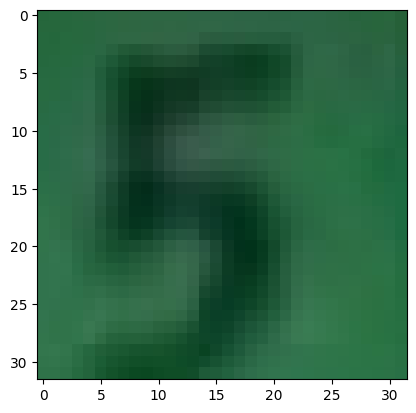

In [ ]:
plt.imshow(x_ts[0])

In [ ]:
#This cell augments an image and then converts it to 1D array

datagen = ImageDataGenerator(
        height_shift_range=0.10,
        rotation_range=15.0,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest')

def get_aug1d(x,y):
  dataset = []
  labels = []
  for (image,yi) in zip(x,y):
    aug_arr = []
    img2 = image
    pix = img_to_array(img2)
    pix = pix.reshape((1,) + pix.shape)
    extra = 1
    start = 1
    for batch in datagen.flow(pix, batch_size=1):
        aug_arr.append(batch[0])
        start += 1
        if start>extra:
            break

    for aug_img in aug_arr:
        sd = aug_img.shape[0]
        rad = sd//2
        vis2 = {}
        pixe = get_pixels(aug_img,rad,vis2,sd)
        tem = []
        for i in range(0,len(pixe)):
            if i%2==0:
                for j in range(0,len(pixe[i])):
                    tem.append(pixe[i][j])
            else:
                for j in range(len(pixe[i])-1,-1,-1):
                    tem.append(pixe[i][j])
        dataset.append(tem)
        labels.append(yi)
  return dataset,labels

In [ ]:
#This cell converts image into 1D array
def get_1d(x,y):
  dataset = []
  labels = []
  for (image,yi) in zip(x,y):
    side = image.shape[0]
    radius = side//2 #Circular region radius
    vis = {} #Used to generate binary mask for image
    pixel_array = get_pixels(image, radius, vis, side)
    temp = []

    for i in range(0,len(pixel_array)):
      #Append array in final dataset in alternate reverse form
      #This preserves spatial relationships as it maintains data continuity
        if i%2==0:
            for j in range(0,len(pixel_array[i])):
                temp.append(pixel_array[i][j])
        else:
            for j in range(len(pixel_array[i])-1,-1,-1):
                temp.append(pixel_array[i][j])
    dataset.append(temp)
    labels.append(yi)
  return dataset,labels

In [ ]:
#Convert images to 1D array (noormal and augmented ones)
trainx_normal, trainy_normal = get_1d(x_tr,y_tr)
trainx_aug, trainy_aug = get_aug1d(x_tr,y_tr)
testx_normal, testy_normal = get_1d(x_ts,y_ts)

In [ ]:
#Save datasets
#Note: The dataset (pixel array) saved in csv file is kind of a string
save_csv(trainx_normal, trainy_normal, 'svhn_train.csv')
save_csv(testx_normal, testy_normal, 'svhn_test.csv')
save_csv(trainx_aug, trainy_aug, 'svhn_aug.csv')

In [ ]:
#Concatenate augmented and normal datasets into training data
p1 = '/content/drive/MyDrive/svhn_aug.csv'
p2 = '/content/drive/MyDrive/svhn_train.csv'
d1 = pd.read_csv(p1)
d2 = pd.read_csv(p2)
x_train_merged = pd.concat([d1, d2])
len(x_train_merged)

146514

In [ ]:
file_name = 'svhn_merged.csv'
file_path = os.path.join('/content/drive/MyDrive', file_name)
x_train_merged.to_csv(file_path, index=False)

In [ ]:
x_final_train, y_train_final = process_csv('svhn_merged.csv') #Final training data
x_final_test, y_test_final = process_csv('svhn_test.csv') #Final testing data

In [ ]:
#One-hot encoding (Pre-process y(s) for softmax layer to predict probability for classification)
num = 10
y_final_train = []
for i in range(len(y_train_final)):
    lst = np.zeros(num).astype(int)
    lst[y_train_final[i]] = 1
    y_final_train.append(lst)
y_final_test = []
for i in range(len(y_test_final)):
    lst = np.zeros(num).astype(int)
    lst[y_test_final[i]] = 1
    y_final_test.append(lst)
y_final_train = np.array(y_final_train)
y_final_test = np.array(y_final_test)

In [ ]:
print(x_final_train.shape)
print(y_final_train.shape)
print(x_final_test.shape)
print(y_final_test.shape)

(146514, 996)
(146514, 10)
(26032, 996)
(26032, 10)


In [ ]:
#Define model
model = Sequential([
    Input(shape=(x_final_train.shape[1],1)),

# 1st Convolutional block
    Conv1D(filters=16,kernel_size=3,activation='relu'),
    Conv1D(filters=16,kernel_size=3,activation='relu'),
    Dropout(0.1),
    MaxPooling1D(pool_size=2),

# 2nd Convolutional block
    Conv1D(filters=32,kernel_size=3,activation='relu'),
    Conv1D(filters=32,kernel_size=3,activation='relu'),
    Dropout(0.1),
    MaxPooling1D(pool_size=2),

# 3rd Convolutional block
    Conv1D(filters=64,kernel_size=3,activation='relu'),
    Conv1D(filters=64,kernel_size=3,activation='relu'),
    Dropout(0.1),
    MaxPooling1D(pool_size=2),

    Flatten(),

    Dense(1024,activation='relu'),
    Dropout(0.3),
    Dense(512,activation='relu'),
    Dropout(0.3),
    Dense(10,activation='softmax')
  ])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 994, 16)           64        
                                                                 
 conv1d_19 (Conv1D)          (None, 992, 16)           784       
                                                                 
 dropout_8 (Dropout)         (None, 992, 16)           0         
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 496, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (None, 494, 32)           1568      
                                                                 
 conv1d_21 (Conv1D)          (None, 492, 32)           3104      
                                                      

In [ ]:
history = model.fit(x_final_train, y_final_train, validation_data = (x_final_test,y_final_test), epochs = 30, batch_size = 3000)

Epoch 1/30
49/49 [==============================] - 20s 352ms/step - loss: 2.2402 - accuracy: 0.1855 - val_loss: 2.1740 - val_accuracy: 0.1965
Epoch 2/30
49/49 [==============================] - 13s 274ms/step - loss: 1.6436 - accuracy: 0.4404 - val_loss: 0.9986 - val_accuracy: 0.6921
Epoch 3/30
49/49 [==============================] - 13s 272ms/step - loss: 0.9747 - accuracy: 0.6875 - val_loss: 0.6678 - val_accuracy: 0.7974
Epoch 4/30
49/49 [==============================] - 13s 273ms/step - loss: 0.7700 - accuracy: 0.7553 - val_loss: 0.5733 - val_accuracy: 0.8313
Epoch 5/30
49/49 [==============================] - 14s 281ms/step - loss: 0.6696 - accuracy: 0.7880 - val_loss: 0.5124 - val_accuracy: 0.8479
Epoch 6/30
49/49 [==============================] - 13s 270ms/step - loss: 0.6028 - accuracy: 0.8085 - val_loss: 0.4836 - val_accuracy: 0.8576
Epoch 7/30
49/49 [==============================] - 14s 283ms/step - loss: 0.5545 - accuracy: 0.8240 - val_loss: 0.4559 - val_accuracy: 0.8631

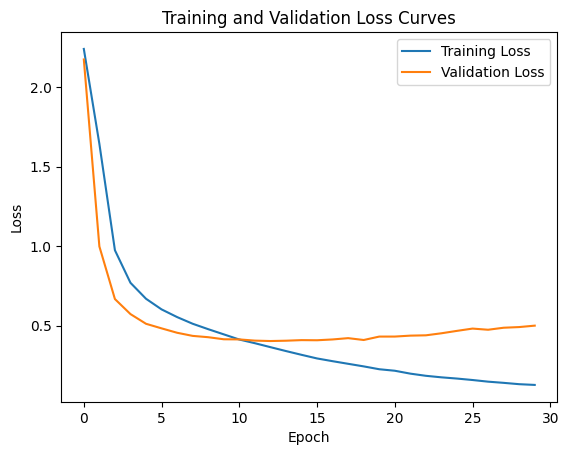

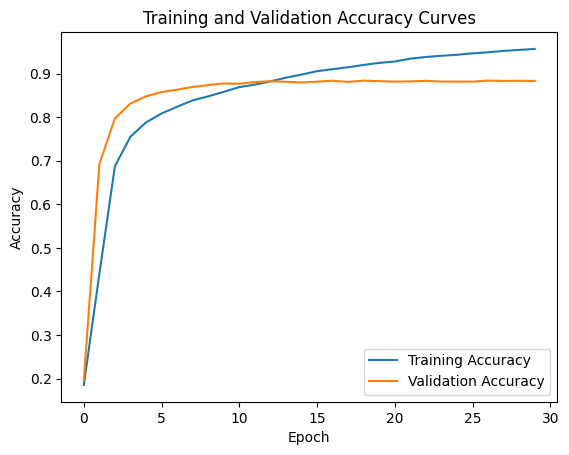

In [ ]:
#Plot training and validation loss curve
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()

# Plot training and validation accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()

plt.show()